In [1]:
import numpy as np, cv2, tensorflow as tf
from glob import glob

from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import tensorflow as tf
from google.colab import drive
drive.mount('/content/drive')


np.random.seed(42)
tf.random.set_seed(42)
!unzip /content/drive/MyDrive/TTDS/data.zip -d extracted_files/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Archive:  /content/drive/MyDrive/TTDS/data.zip
   creating: extracted_files/extracted_images/
  inflating: extracted_files/extracted_images/1.png  
  inflating: extracted_files/extracted_images/10.png  
  inflating: extracted_files/extracted_images/100.png  
  inflating: extracted_files/extracted_images/101.png  
  inflating: extracted_files/extracted_images/102.png  
  inflating: extracted_files/extracted_images/103.png  
  inflating: extracted_files/extracted_images/104.png  
  inflating: extracted_files/extracted_images/105.png  
  inflating: extracted_files/extracted_images/106.png  
  inflating: extracted_files/extracted_images/107.png  
  inflating: extracted_files/extracted_images/108.png  
  inflating: extracted_files/extracted_images/109.png  
  inflating: extracted_files/extracted_images/11.png  
  inflating: extracted_files/extracted_images/110.png

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.24 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


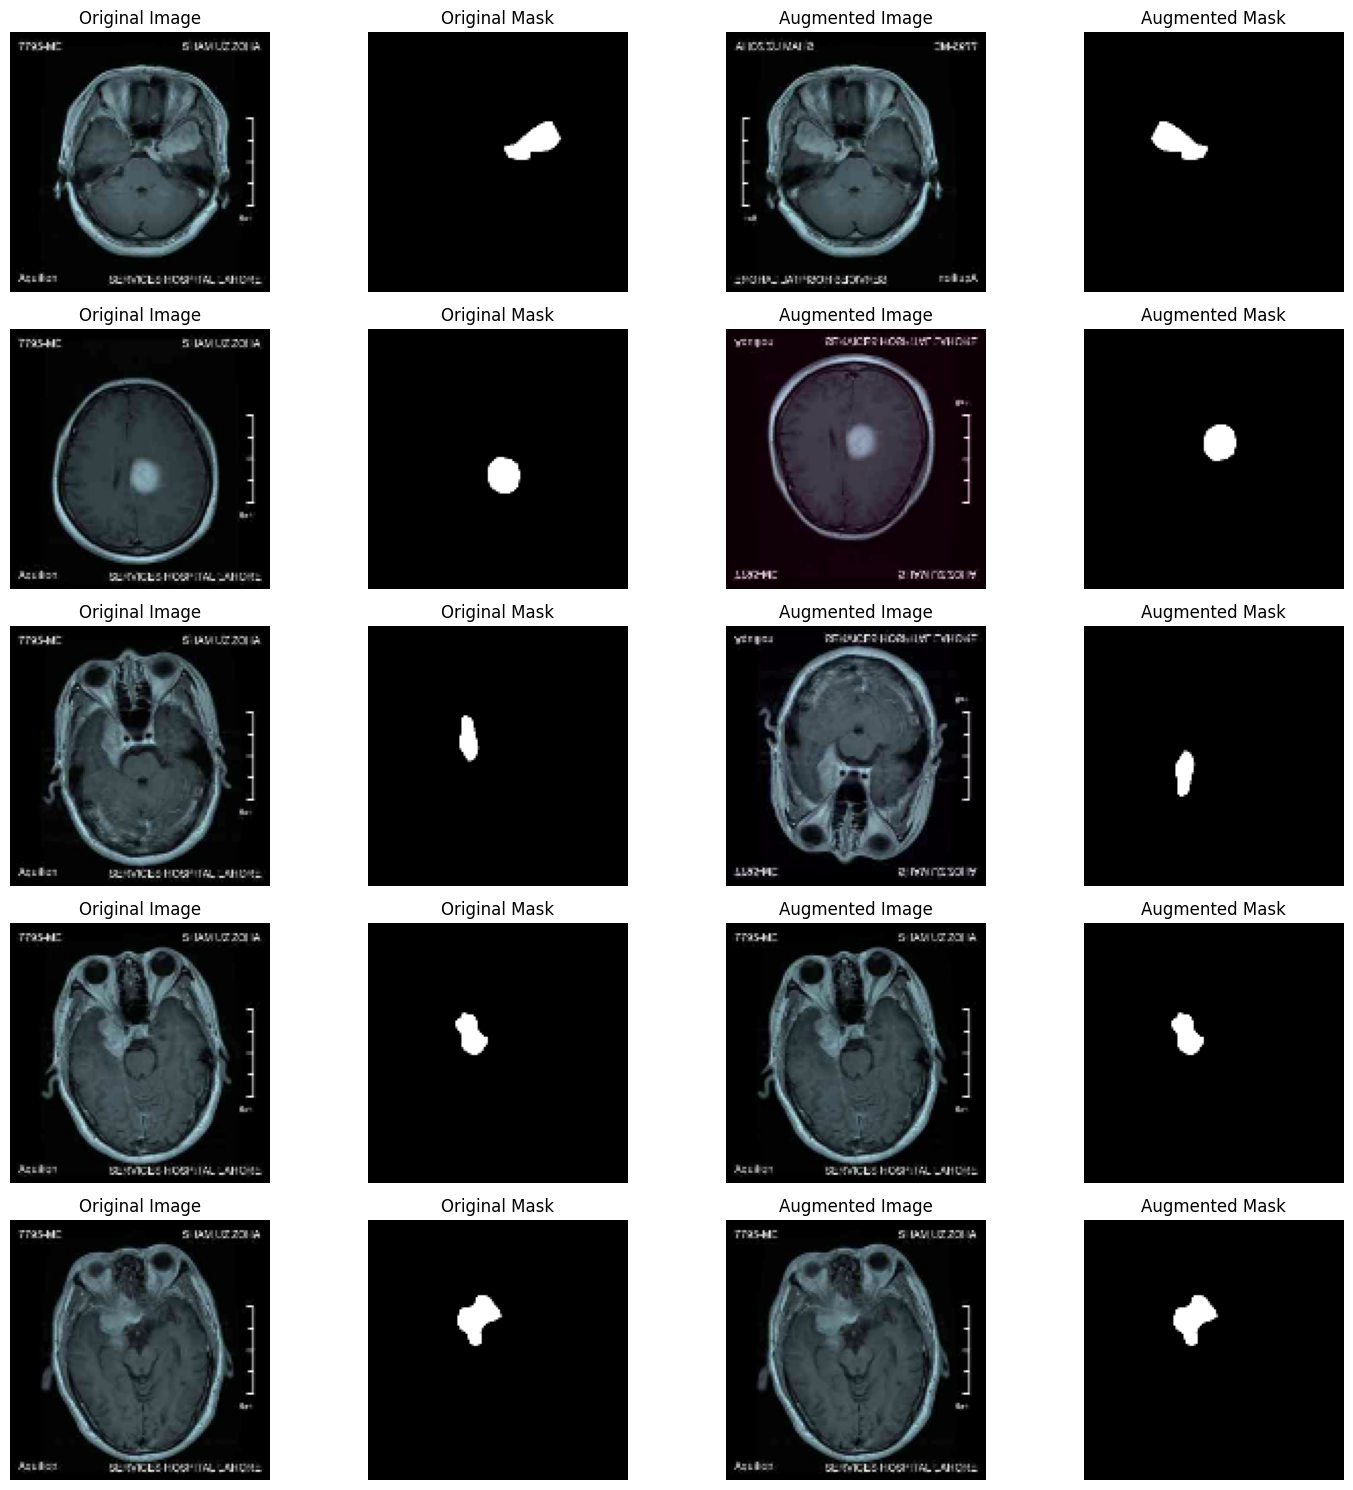

In [ ]:
import albumentations as A
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np

# Define augmentation pipeline
augmentor = A.Compose([
    A.RandomCrop(width=128, height=128),  # Set to your U-Net input size
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.RandomGamma(p=0.2),
    A.RGBShift(p=0.2)
])

# Function to read and augment images and masks
def augment_and_display(image_path, mask_path, augmentor, ax, idx):
    # Read original image and mask
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    # Resize image and mask
    image = cv2.resize(image, (128, 128))
    mask = cv2.resize(mask, (128, 128))

    # Apply augmentations
    augmented = augmentor(image=image, mask=mask)
    augmented_image = augmented['image']
    augmented_mask = augmented['mask']

    # Display original and augmented side-by-side
    ax[idx, 0].imshow(image)
    ax[idx, 0].set_title('Original Image')
    ax[idx, 0].axis('off')

    ax[idx, 1].imshow(mask, cmap='gray')
    ax[idx, 1].set_title('Original Mask')
    ax[idx, 1].axis('off')

    ax[idx, 2].imshow(augmented_image)
    ax[idx, 2].set_title('Augmented Image')
    ax[idx, 2].axis('off')

    ax[idx, 3].imshow(augmented_mask, cmap='gray')
    ax[idx, 3].set_title('Augmented Mask')
    ax[idx, 3].axis('off')


# Paths to your data
images_dir = "/content/extracted_files/extracted_images"
masks_dir = "/content/extracted_files/extracted_masks"

# List of images and masks (first 5 for this example)
image_paths = sorted(os.listdir(images_dir))[:5]
mask_paths = sorted(os.listdir(masks_dir))[:5]

# Combine full paths
image_paths = [os.path.join(images_dir, img) for img in image_paths]
mask_paths = [os.path.join(masks_dir, msk) for msk in mask_paths]

# Create a figure to display the results
fig, ax = plt.subplots(5, 4, figsize=(15, 15))

# Apply augmentation and display results
for i in range(5):
    augment_and_display(image_paths[i], mask_paths[i], augmentor, ax, i)

plt.tight_layout()
plt.show()



In [ ]:
import numpy as np, tensorflow as tf
from tensorflow.keras import backend as B
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
import os

smooth=1e-15



@tf.keras.utils.register_keras_serializable()
def dice_coef(y_true, y_pred):
    y_true= tf.keras.layers.Flatten()(y_true)
    y_pred= tf.keras.layers.Flatten()(y_pred)
    intersection= tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth)/(tf.reduce_sum(y_true)+tf.reduce_sum(y_pred))


@tf.keras.utils.register_keras_serializable()
def dice_loss(y_true, y_pred):
    return 1.0- dice_coef(y_true, y_pred)

def conv_block(num_filters, inputs):
    x= Conv2D(num_filters, 3, padding='same')(inputs)
    x= BatchNormalization()(x)
    x= Activation("relu")(x)

    x= Conv2D(num_filters, 3, padding='same')(x)
    x= BatchNormalization()(x)
    x= Activation("relu")(x)

    return x

def encoder_block(inputs, num_filters):
    x= conv_block(num_filters, inputs)
    p=MaxPooling2D((2, 2))(x)
    return x, p


def decoder_block(inputs, p, num_filters):
    u= Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same')(inputs)
    print(u.shape,'======', p.shape)
    u= concatenate([u, p])
    c= conv_block(num_filters, u)
    return c

def build_unet(input_shape):
    inputs= Input(input_shape)
    c1, p1= encoder_block(inputs, 16)
    c2, p2= encoder_block(p1, 32)
    c3, p3= encoder_block(p2, 64)
    c4, p4= encoder_block(p3, 128)
    p5= conv_block(256, p4)
    c6=decoder_block(p5, c4, 128)
    c7=decoder_block(c6, c3, 64)
    c8=decoder_block(c7, c2, 32)
    c9=decoder_block(c8, c1, 16)

    outputs= Conv2D(1, 1, padding='same', activation='sigmoid')(c9)
    print(outputs)

    model= Model(inputs, outputs, name='UNET')
    return model

# model= build_unet((128, 128, 3))
# print(model.summary())
import albumentations as A
from albumentations.core.composition import OneOf
from albumentations.pytorch import ToTensorV2  # Optional, not needed for TF
import cv2

SIZE= (128, 128)
# Define path to save the model in Google Drive

def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

def load_dataset(path, split=0.2):
    images= sorted(glob(os.path.join(path, 'extracted_images', '*.png')))
    masks= sorted(glob(os.path.join(path, 'extracted_masks', '*.png')))
    print(len(images),'---------------')
    split_size= int(len(images)*split)
    train_x, valid_x= train_test_split(images, test_size=split_size, random_state=42)
    train_y, valid_y= train_test_split(masks, test_size=split_size, random_state=42)

    train_x, test_x= train_test_split(train_x, test_size=split_size, random_state=42)
    train_y, test_y= train_test_split(train_y, test_size=split_size, random_state=42)

    return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)



augmentor = A.Compose([
    A.RandomCrop(width=128, height=128),  # Set to your image size
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.RandomGamma(p=0.2),
    A.RGBShift(r_shift_limit=20, g_shift_limit=20, b_shift_limit=20, p=0.2)
])


def augment_image_and_mask(image, mask):
    """Augment both the image and mask using Albumentations."""
    # Convert image and mask to uint8 for Albumentations
    image = (image * 255).astype(np.uint8)
    mask = (mask * 255).astype(np.uint8)

    # Apply augmentations
    data = augmentor(image=image, mask=mask)
    augmented_image = data["image"]
    augmented_mask = data["mask"]

    # Convert back to float32 and rescale
    augmented_image = augmented_image.astype(np.float32) / 255.0
    augmented_mask = augmented_mask.astype(np.float32) / 255.0

    return augmented_image, augmented_mask


def _parse_with_augmentation(image_path, mask_path):
    """Read and augment the image and mask."""
    # Apply augmentations
    image, mask = augment_image_and_mask(image, mask)

    # Convert to float32 and expand mask dims
    image = image.astype(np.float32)
    mask = np.expand_dims(mask.astype(np.float32), axis=-1)

    return image, mask

def tf_parse(x, y):
    def _parse_with_augmentation(image_path, mask_path):
      """Read and augment the image and mask."""
      # Read image and mask
      image_path = image_path.decode()
      mask_path = mask_path.decode()

      image = cv2.imread(image_path, cv2.IMREAD_COLOR)
      image = cv2.resize(image, SIZE)
      image = image / 255.0  # Scale between 0 and 1

      mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
      mask = cv2.resize(mask, SIZE)
      mask = mask / 255.0  # Scale between 0 and 1

      # Apply augmentations
      image, mask = augment_image_and_mask(image, mask)

      # Convert to float32 and expand mask dims
      image = image.astype(np.float32)
      mask = np.expand_dims(mask.astype(np.float32), axis=-1)

      return image, mask

    x, y= tf.numpy_function(_parse_with_augmentation, [x, y], [tf.float32, tf.float32])
    x.set_shape([SIZE[0], SIZE[1], 3])
    y.set_shape([SIZE[0], SIZE[1], 1])
    return x,y

def tf_dataset(X, Y, batch=2):
    dataset = tf.data.Dataset.from_tensor_slices((X, Y))
    dataset = dataset.map(tf_parse, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.batch(batch).prefetch(tf.data.experimental.AUTOTUNE)
    return dataset



if __name__=="__main__":
    create_dir("/content/drive/MyDrive/TTDS/files/")

    #hyperparameter
    batch_size=4
    lr= 1e-4
    num_epochs=500
    model_path=os.path.join("/content/drive/MyDrive/TTDS/files/", "model.keras")
    csv_path= os.path.join("/content/drive/MyDrive/TTDS/files/", "log.csv")
    (train_x, train_y), (valid_x, valid_y), (test_x, test_y)=load_dataset('/content/extracted_files')

    print("train: {}- {}".format(len(train_x),len(train_y)))
    print("valid: {}- {}".format(len(valid_x),len(valid_y)))
    print("test: {}- {}".format(len(test_x),len(test_y)))


    train_dataset= tf_dataset(train_x, train_y, batch_size)
    valid_dataset= tf_dataset(valid_x, valid_y, batch_size)

    test_dataset= tf_dataset(test_x, test_y, 16)
    ###Model

    model= build_unet((128, 128, 3))
    model.compile(loss=dice_loss, optimizer=Adam(lr), metrics=[dice_coef])

    callbacks= [
        ModelCheckpoint(model_path, verbose=1, save_best_only=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1),
        CSVLogger(csv_path),
        # EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=False)
    ]

    model.fit(
        train_dataset, epochs=num_epochs,validation_data=valid_dataset,
        callbacks=callbacks
    )

    model.save('/content/drive/MyDrive/TTDS/model_k_frmt.keras')


    # new_model=tf.keras.models.load_model('model_k_frmt.keras',custom_objects={'dice_loss': dice_loss})

    # loss, acc= new_model.evaluate(test_dataset, verbose=2)

    # print(loss, acc)

180 ---------------
train: 108- 108
valid: 36- 36
test: 36- 36
(None, 16, 16, 128) ====== (None, 16, 16, 128)
(None, 32, 32, 64) ====== (None, 32, 32, 64)
(None, 64, 64, 32) ====== (None, 64, 64, 32)
(None, 128, 128, 16) ====== (None, 128, 128, 16)
<KerasTensor shape=(None, 128, 128, 1), dtype=float32, sparse=False, name=keras_tensor_339>
Epoch 1/500
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 855ms/step - dice_coef: 0.0415 - loss: 0.9585
Epoch 1: val_loss improved from inf to 0.96381, saving model to /content/drive/MyDrive/TTDS/files/model.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 44s 970ms/step - dice_coef: 0.0416 - loss: 0.9584 - val_dice_coef: 0.0362 - val_loss: 0.9638 - learning_rate: 1.0000e-04
Epoch 2/500
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 876ms/step - dice_coef: 0.0680 - loss: 0.9320
Epoch 2: val_loss improved from 0.96381 to 0.96178, saving model to /content/drive/MyDrive/TTDS/files/model.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - dice_coef: 0.0681 - loss: 0.9319 - val_dice_coef: 0.0382 - val_loss: 0

## TESTING


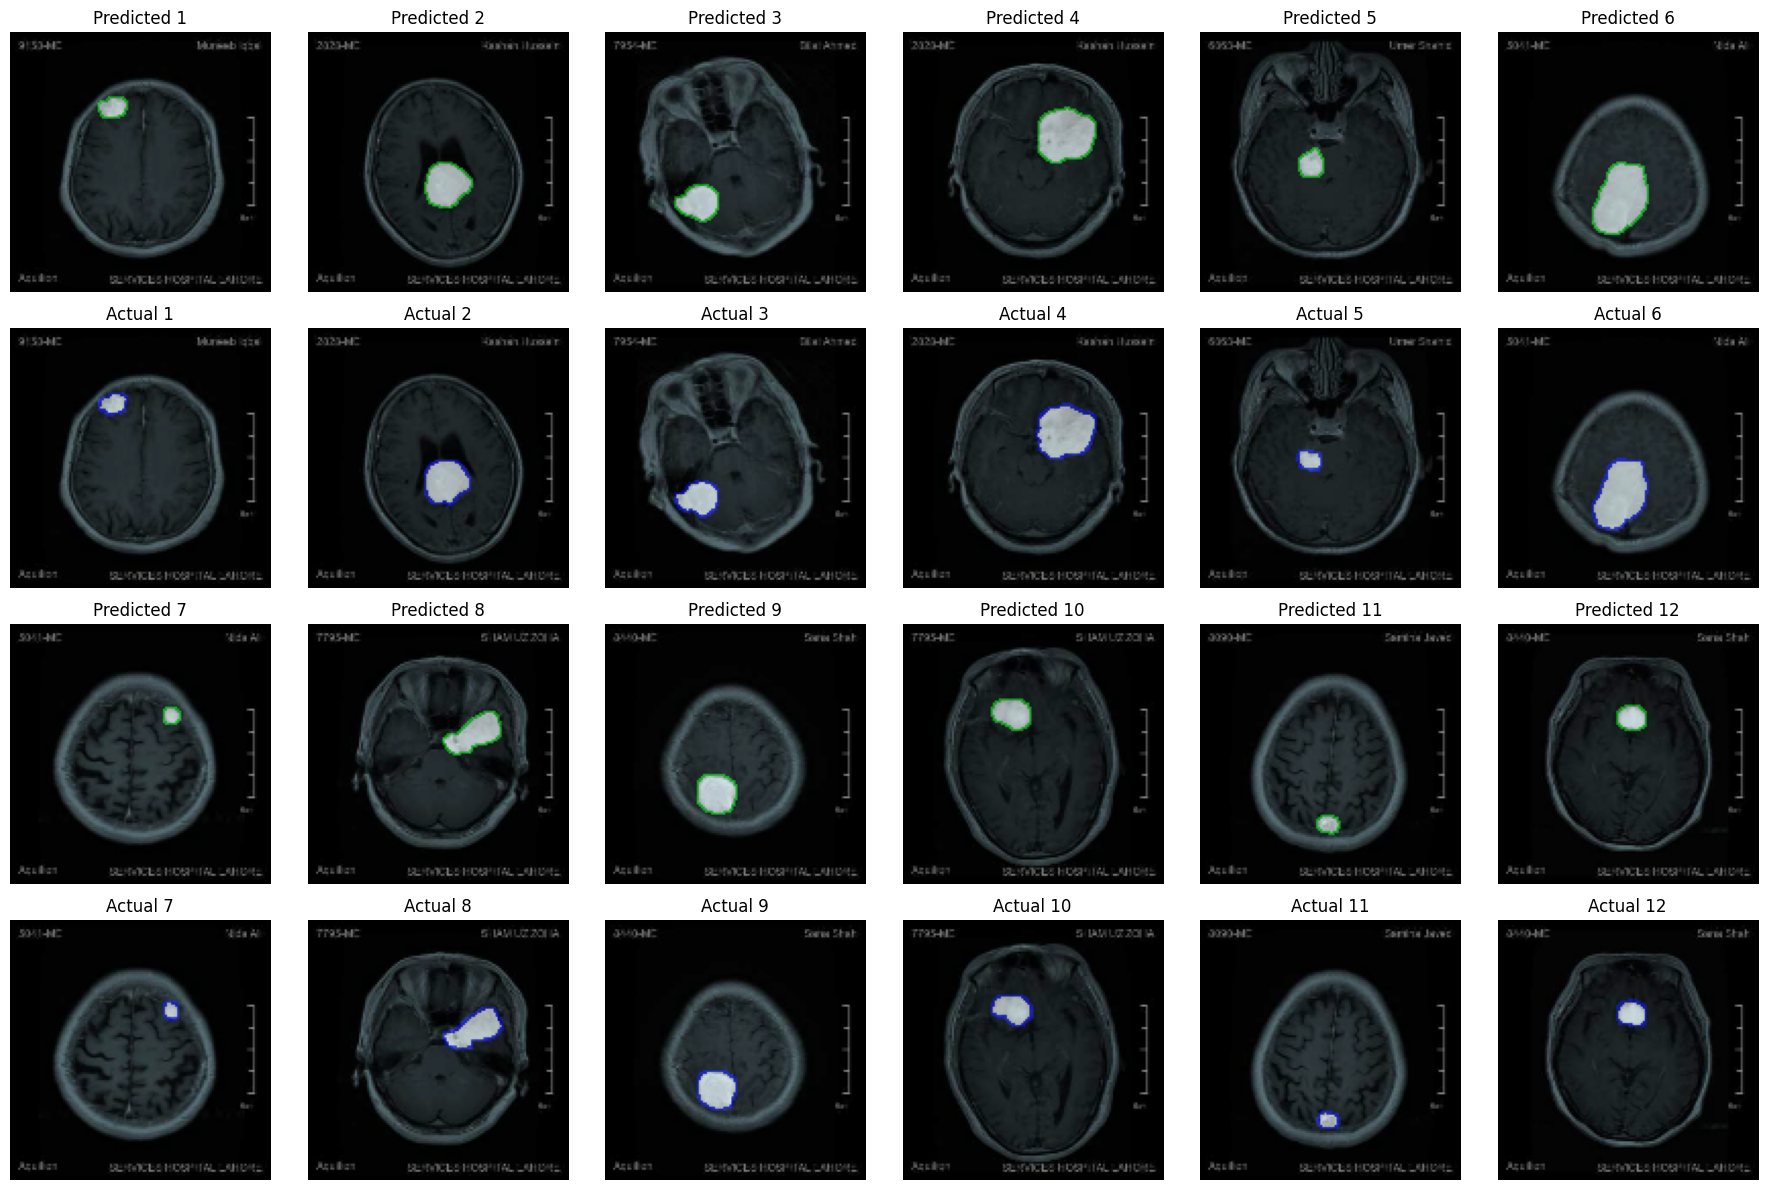

In [ ]:
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"]="2"

import cv2, matplotlib.pyplot as plt, os, numpy as np
from tensorflow.keras.utils import CustomObjectScope
import tensorflow as tf


smooth=1e-15



@tf.keras.utils.register_keras_serializable()
def dice_coef(y_true, y_pred):
    y_true= tf.keras.layers.Flatten()(y_true)
    y_pred= tf.keras.layers.Flatten()(y_pred)
    intersection= tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth)/(tf.reduce_sum(y_true)+tf.reduce_sum(y_pred))


@tf.keras.utils.register_keras_serializable()
def dice_loss(y_true, y_pred):
    return 1.0- dice_coef(y_true, y_pred)

images= os.listdir('/content/extracted_files/extracted_images')
masks= os.listdir('/content/extracted_files/extracted_masks')


def segment(image, mask, color):
    kernel= np.ones((3, 3), np.uint8)
    dilated_mask= cv2.dilate(mask, kernel, iterations=1)
    border= dilated_mask-mask
    #color
    mask_color= cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)
    mask_color[border>0]= color
    alpha=0.5
    overlay_image= cv2.addWeighted(image, 1-alpha, mask_color, alpha, 0)
    overlay_image= cv2.cvtColor(overlay_image, cv2.COLOR_BGR2RGB)
    return overlay_image


with CustomObjectScope({"dice_coef":dice_coef, "dice_loss": dice_loss}):
    model = tf.keras.models.load_model(os.path.join("/content/drive/MyDrive/TTDS/", "model_k_frmt.keras"))

# model.summary()
segmented_actual=[]
segmented_y_pred=[]


for j in range(12):
    img=cv2.imread(os.path.join('/content/extracted_files/extracted_images/',images[j]))
    img= cv2.resize(img, (128, 128))
    x= img/255.0
    x= np.expand_dims(x, axis=0)

    y_pred= model.predict(x, verbose=0)[0]
    y_pred= np.squeeze(y_pred, axis=-1)
    y_pred= y_pred>=0.5
    y_pred= (y_pred*255).astype(np.uint8)
    segmented_pred= segment(img, y_pred, [0, 255, 0])
    segmented_y_pred.append(segmented_pred)
    #actual mask
    mask= cv2.imread(os.path.join('/content/extracted_files/extracted_masks/',masks[j]), cv2.IMREAD_GRAYSCALE)
    mask= cv2.resize(mask, (128, 128))
    mask= (mask).astype(np.uint8)
    segmented_truth= segment(img, mask, [255, 0, 0])
    #append for showing
    segmented_actual.append(segmented_truth)

fig, axes = plt.subplots(4, 6, figsize=(18, 12))  # Adjust size as needed

# Plot the first 6 predicted images in row 1
for i in range(6):
    axes[0, i].imshow(segmented_y_pred[i])
    axes[0, i].set_title("Predicted " + str(i+1))
    axes[0, i].axis("off")  # Hide the axes

# Plot the first 6 actual images in row 2
for i in range(6):
    axes[1, i].imshow(segmented_actual[i])
    axes[1, i].set_title("Actual " + str(i+1))
    axes[1, i].axis("off")  # Hide the axes

# Plot the next 6 predicted images in row 3
for i in range(6, 12):
    axes[2, i-6].imshow(segmented_y_pred[i])
    axes[2, i-6].set_title("Predicted " + str(i+1))
    axes[2, i-6].axis("off")  # Hide the axes

# Plot the next 6 actual images in row 4
for i in range(6, 12):
    axes[3, i-6].imshow(segmented_actual[i])
    axes[3, i-6].set_title("Actual " + str(i+1))
    axes[3, i-6].axis("off")  # Hide the axes

plt.tight_layout()  # Adjust spacing between subplots
plt.show()